In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# Helper classes
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.tensor(ratings['user_id'].values, dtype=torch.long)
        self.book_ids = torch.tensor(ratings['book_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['rating_centered'].values, dtype=torch.float)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.book_ids[idx], self.ratings[idx]
    
    
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
# Load Data
ratings = pd.read_csv("/kaggle/input/goodbooks-10k-extended/ratings.csv")
books = pd.read_csv("/kaggle/input/goodbooks-10k-extended/books_enriched.csv")

# Remove non-english books
books = books.drop(books[books["language_code"] != "eng"].index)

# Remove duplicate titles
books = books.drop_duplicates(subset = ["title"])

# Filter ratings dataset to include only book IDs present in the new books dataset
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Mean center the ratings
ratings['rating_centered'] = ratings.groupby('user_id')['rating'].transform(lambda x: x - x.mean())

# Extract high ratings for later use in evaluation
high_rated = ratings[ratings['rating'] >= 4]
high_rated = high_rated.groupby('user_id')['book_id'].apply(list).reset_index(name='high_rated_books')

In [ ]:
# Encode user and book IDs
user_enc = LabelEncoder()
ratings['user_id'] = user_enc.fit_transform(ratings['user_id'])
book_enc = LabelEncoder()
ratings['book_id'] = book_enc.fit_transform(ratings['book_id'])

# Split Data
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [5]:
class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_books, embedding_size):
        super(NeuralCollaborativeFiltering, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.book_embedding = nn.Embedding(num_books, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, user_ids, book_ids):
        user_embeds = self.user_embedding(user_ids)
        book_embeds = self.book_embedding(book_ids)
        x = torch.cat([user_embeds, book_embeds], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# Initialize model
num_users = ratings['user_id'].nunique()
num_books = ratings['book_id'].nunique()
b_ids = list(pd.DataFrame(ratings)['book_id'].unique())

embedding_size = 64
model = NeuralCollaborativeFiltering(num_users, num_books, embedding_size).to('cuda')

# Define loss function, optimizier, and early stopping
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00146)
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [8]:
def rmse(preds, y):
    return torch.sqrt(torch.mean((preds - y) ** 2))

def mae(preds, y):
    return torch.mean(torch.abs(preds - y))

In [9]:
# Metrics to be collected each epoch 
train_losses = []
val_losses = []
train_rmses = []
val_rmses = []
train_maes = []
val_maes = []

# Maximimum number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    
    # Training loop
    model.train()
    train_loss = 0
    train_rmse = 0
    train_mae = 0
    
    for user_ids, book_ids, ratings in train_loader:
        user_ids = user_ids.to('cuda')
        book_ids = book_ids.to('cuda')
        ratings = ratings.to('cuda')
        
        optimizer.zero_grad()
        outputs = model(user_ids, book_ids).squeeze()
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_rmse += rmse(outputs, ratings).item()
        train_mae += mae(outputs, ratings).item()
    
    # Update training statistics
    train_loss /= len(train_loader)
    train_rmse /= len(train_loader)
    train_mae /= len(train_loader)
    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    
    # Validation loop
    model.eval()
    val_loss = 0
    val_rmse = 0
    val_mae = 0
        
    with torch.no_grad():
        for user_ids, book_ids, ratings in test_loader:
            user_ids = user_ids.to('cuda')
            book_ids = book_ids.to('cuda')
            ratings = ratings.to('cuda')

            outputs = model(user_ids, book_ids).squeeze()
            loss = criterion(outputs, ratings)
            
            val_loss += loss.item()
            val_rmse += rmse(outputs, ratings).item()
            val_mae += mae(outputs, ratings).item()
    
    # Update validation statistics
    val_loss /= len(test_loader)
    val_rmse /= len(test_loader)
    val_mae /= len(test_loader)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_maes.append(val_mae)
    
    print('Epoch %d || Train Loss: %.2f || Validation Loss: %.2f' % (epoch + 1, train_loss, val_loss))
    
    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1 || Train Loss: 0.74 || Validation Loss: 0.73
Epoch 2 || Train Loss: 0.73 || Validation Loss: 0.72
Epoch 3 || Train Loss: 0.72 || Validation Loss: 0.72
Epoch 4 || Train Loss: 0.72 || Validation Loss: 0.71
Epoch 5 || Train Loss: 0.71 || Validation Loss: 0.71
Epoch 6 || Train Loss: 0.71 || Validation Loss: 0.71
Epoch 7 || Train Loss: 0.70 || Validation Loss: 0.71
Epoch 8 || Train Loss: 0.70 || Validation Loss: 0.71
Epoch 9 || Train Loss: 0.70 || Validation Loss: 0.71
Epoch 10 || Train Loss: 0.69 || Validation Loss: 0.71
Epoch 11 || Train Loss: 0.68 || Validation Loss: 0.70
Epoch 12 || Train Loss: 0.68 || Validation Loss: 0.70
Epoch 13 || Train Loss: 0.68 || Validation Loss: 0.70
Epoch 14 || Train Loss: 0.67 || Validation Loss: 0.70
Epoch 15 || Train Loss: 0.67 || Validation Loss: 0.70
Epoch 16 || Train Loss: 0.66 || Validation Loss: 0.70
Epoch 17 || Train Loss: 0.66 || Validation Loss: 0.69
Epoch 18 || Train Loss: 0.66 || Validation Loss: 0.69
Epoch 19 || Train Loss: 0.65 || Valid

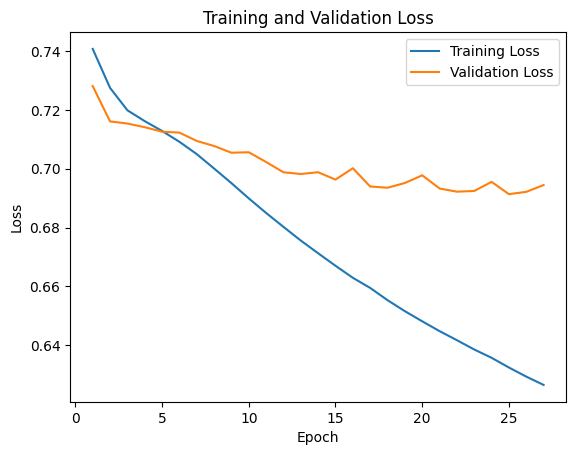

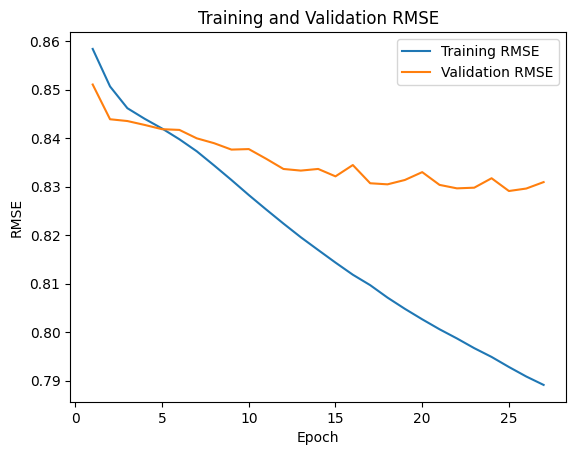

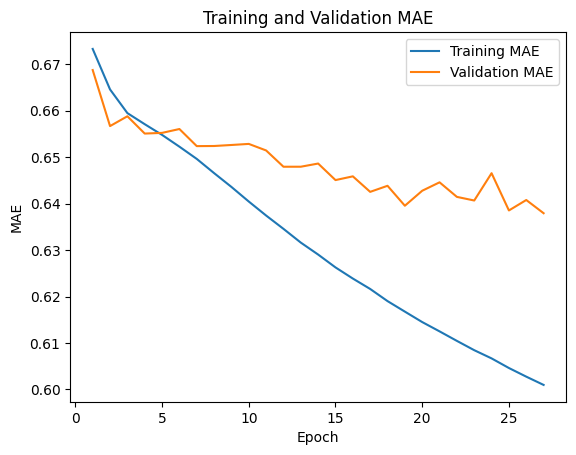

In [10]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting RMSE
plt.plot(range(1, len(train_rmses) + 1), train_rmses, label='Training RMSE')
plt.plot(range(1, len(val_rmses) + 1), val_rmses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

# Plotting MAE
plt.plot(range(1, len(train_maes) + 1), train_maes, label='Training MAE')
plt.plot(range(1, len(val_maes) + 1), val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [11]:
# Save and load model
torch.save(model.state_dict(), 'ncf_model.pth')
model.load_state_dict(torch.load('ncf_model.pth'))

# Extract book embeddings
book_weights = model.book_embedding.weight.data.cpu().numpy()

# Extract book titles
titles = dict(zip(book_enc.transform(books['book_id']), books['title']))

In [ ]:
# Create visualization of book embeddings
with open('vecs.tsv', 'w') as out_v, open('meta.tsv', 'w') as out_m:
    for b_id in b_ids:
        if b_id in titles:
            book = titles[b_id]
            embeddings = book_weights[b_id]
            out_m.write(book + "\n")
            out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

In [ ]:
# Normalize book embeddings
book_weights = book_weights / np.linalg.norm(book_weights, axis=1).reshape(-1, 1)

In [13]:
# Find similar books using dot product 
def find_similar_books(book_ids, book_weights, k=5):
    
    # Compute the average embedding for the given book IDs
    book_vecs = book_weights[book_ids]
    avg_book_vec = np.mean(book_vecs, axis=0)

    # Calculate similarity scores
    similarity = np.dot(book_weights, avg_book_vec)

    # Get the indices of the top k similar books
    similar_books = np.argsort(-similarity)[1:k+1]

    return similar_books

In [1]:
# Example Book 1
book_id = book_enc.transform([3])[0]  
similar_books = find_similar_books([book_id], book_weights)

print(f"Because you read {titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, titles[similar_book_id])

Because you read Twilight (Twilight, #1)
1 New Moon (Twilight, #2)
2 Eclipse (Twilight, #3)
3 Breaking Dawn (Twilight, #4)
4 The Twilight Collection (Twilight, #1-3)
5 The Twilight Saga (Twilight, #1-4)


In [3]:
# Example Book 2
book_id = book_enc.transform([5])[0]  
similar_books = find_similar_books([book_id], book_weights)

print(f"Because you read {titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, titles[similar_book_id])

Because you read The Great Gatsby
1 The Catcher in the Rye
2 Of Mice and Men
3 Animal Farm
4 A Tale of Two Cities
5 Lord of the Flies


In [24]:
# Example Book 3
book_id = book_enc.transform([1])[0]
similar_books = find_similar_books([book_id], book_weights, 10)

print(f"Because you read {titles[book_id]}")
for index, similar_book_id in enumerate(similar_books):
    print(index + 1, titles[similar_book_id])

Because you read The Hunger Games (The Hunger Games, #1)
1 Catching Fire (The Hunger Games, #2)
2 The Help
3 The Girl Who Played with Fire (Millennium, #2)
4 The Nightingale
5 The Girl Who Kicked the Hornet's Nest (Millennium, #3)
6 Ready Player One
7 Drums of Autumn (Outlander, #4)
8 The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)
9 A Thousand Splendid Suns
10 A Breath of Snow and Ashes (Outlander, #6)


In [ ]:
# Preparing the ground truth data
to_read = pd.read_csv("/kaggle/input/goodbooks-10k-extended/to_read.csv")
to_read = to_read[to_read['book_id'].isin(books['book_id'])]
to_read = to_read.groupby("user_id")["book_id"].apply(list).reset_index(name="books_to_read")

# Merge and combine lists
combined = pd.merge(to_read, high_rated, on='user_id', how='outer')
combined['books_to_read'] = combined['books_to_read'].apply(lambda x: x if isinstance(x, list) else [])
combined['high_rated_books'] = combined['high_rated_books'].apply(lambda x: x if isinstance(x, list) else [])
combined['ground_truth'] = combined.apply(lambda row: list(set(row['books_to_read'] + row['high_rated_books'])), axis=1)

# Convert to dictionary for fast lookup
ground_truth_dict = combined.set_index('user_id')['ground_truth'].to_dict()

In [ ]:
import random
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommendations(recommendations, ground_truth_dict):
    precisions, recalls, f1s = [], [], []

    for user, recommended_books in recommendations.items():
        if user in ground_truth_dict:
            true_books = ground_truth_dict[user]
            y_true = [1 if book in true_books else 0 for book in recommended_books]
            y_pred = [1] * len(recommended_books)

            precisions.append(precision_score(y_true, y_pred, zero_division=0))
            recalls.append(recall_score(y_true, y_pred, zero_division=0))
            f1s.append(f1_score(y_true, y_pred, zero_division=0))

    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_f1 = sum(f1s) / len(f1s) if f1s else 0

    return avg_precision, avg_recall, avg_f1

In [56]:
def generate_recommendations(user_id, ground_truth_dict, n, k):
    random_books = random.sample(ground_truth_dict[user_id], k)
    random_books_encoded = [book_enc.transform([idx])[0] for idx in random_books]
    
    similar_books_encoded = find_similar_books(random_books_encoded, book_weights, n)
    similar_books = book_enc.inverse_transform(similar_books_encoded)

    return similar_books

# Generate recommendations for each of the 50 random users
n=5
k=3
random_users = np.random.choice(list(ground_truth_dict.keys()), size=50, replace=False)
recommendations = {user: generate_recommendations(user, ground_truth_dict, n, k) for user in random_users}

# Evaluate the recommendations
precision, recall, f1 = evaluate_recommendations(recommendations, ground_truth_dict)
print(f"Precision@{n}: {precision:.2f}, Recall@{n}: {recall:.2f}, F1-score@{n}: {f1:.2f}")

Precision@5: 0.23, Recall@5: 0.82, F1-score@5: 0.35
